In [28]:
# Import Packages
#########################################################################################################################
import pandas as pd, numpy as np
from sqlalchemy import create_engine, MetaData, Table, select
import os, time
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [68]:
df = pd.read_csv('data.csv')

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Before Analyzing lets start by deduping the data set

In [69]:
df = df.drop(['Unnamed: 0'], axis=1)

In [70]:
df = df.drop_duplicates()

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503586 entries, 0 to 513230
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   tconst             503586 non-null  object 
 1   directors          459020 non-null  object 
 2   writers            414458 non-null  object 
 3   titleType          503586 non-null  object 
 4   primaryTitle       503586 non-null  object 
 5   isAdult            503586 non-null  int64  
 6   startYear          503543 non-null  float64
 7   runtimeMinutes     426299 non-null  float64
 8   genres             497136 non-null  object 
 9   category           459143 non-null  object 
 10  job                29099 non-null   object 
 11  primaryProfession  444316 non-null  object 
 12  knownForTitles     455954 non-null  object 
 13  averageRating      503586 non-null  float64
 14  numVotes           503586 non-null  int64  
dtypes: float64(3), int64(2), object(10)
memory usage: 6

In [72]:
df['isAdult'] = pd.Categorical(df['isAdult'])

### Bivariate Analysis for numerical variables 

In [73]:
corr = df.corr()

In [74]:
corr

,startYear,runtimeMinutes,averageRating,numVotes
startYear,1.000000,0.015412,0.142193,0.025265
runtimeMinutes,0.015412,1.000000,-0.068692,0.035455
averageRating,0.142193,-0.068692,1.000000,0.033647
numVotes,0.025265,0.035455,0.033647,1.000000


<AxesSubplot:>

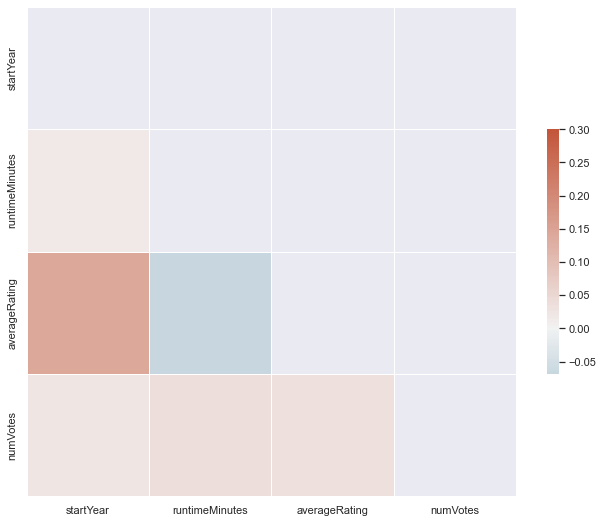

In [75]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

###### From the Chart we can conclude that there is hardly any correlation between the numerical variables and hence we can keep all

### Bivariate Analysis for Categorical variables 

In [76]:
df_cat = df.select_dtypes(include = 'object').copy()

In [77]:
df_cat.head()

,tconst,directors,writers,titleType,primaryTitle,genres,category,job,primaryProfession,knownForTitles
0,tt0000001,nm0005690,NaN,short,Carmencita,"Documentary,Short",NaN,NaN,NaN,NaN
1,tt0000002,nm0721526,NaN,short,Le clown et ses chiens,"Animation,Short",NaN,NaN,NaN,NaN
2,tt0000005,nm0005690,NaN,short,Blacksmith Scene,"Comedy,Short",NaN,NaN,NaN,NaN
3,tt0000005,nm0005690,NaN,short,Blacksmith Scene,"Comedy,Short",actor,NaN,actor,tt0000005
6,tt0000006,nm0005690,NaN,short,Chinese Opium Den,Short,NaN,NaN,NaN,NaN


#### Finding out the percentage of missing values in the categorical data set

In [78]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

In [79]:
missing_value_df.sort_values('percent_missing', inplace=True)

In [80]:
missing_value_df

,column_name,percent_missing
tconst,tconst,0.000000
titleType,titleType,0.000000
primaryTitle,primaryTitle,0.000000
isAdult,isAdult,0.000000
averageRating,averageRating,0.000000
numVotes,numVotes,0.000000
startYear,startYear,0.008539
genres,genres,1.280814
category,category,8.825305
directors,directors,8.849730


In [81]:
df_cat['averageRating'] = df.loc[df_cat.index, 'averageRating'].copy()

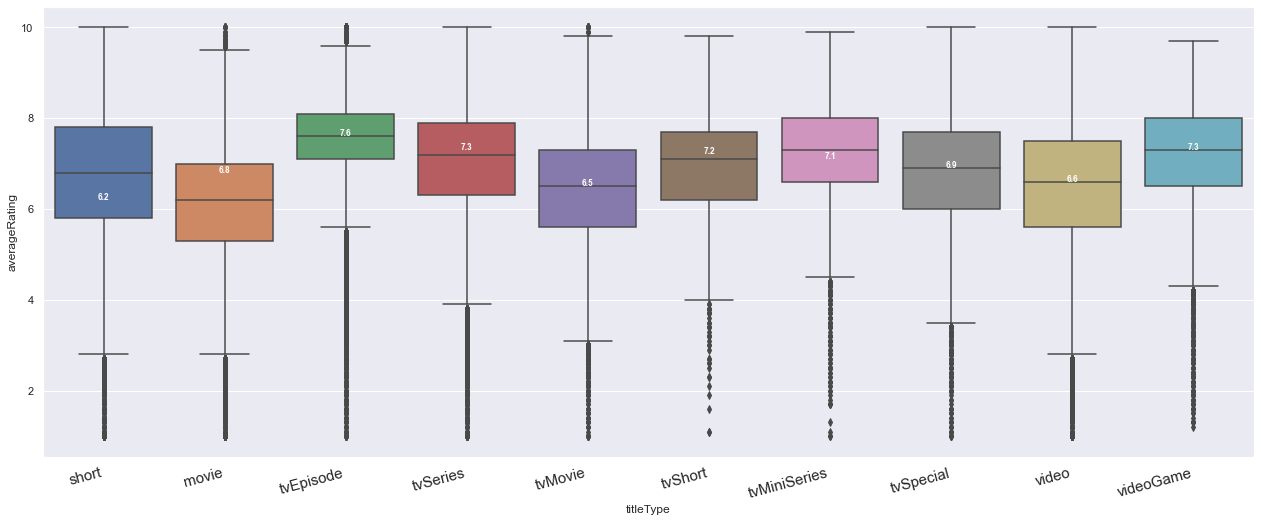

In [82]:
ax = sns.boxplot(data = df_cat, x='titleType', y='averageRating')
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right", fontsize=15)
sns.set(rc={'figure.figsize':(21.7,8.27)})
medians = df.groupby(['titleType'])['averageRating'].median()
vertical_offset = df['averageRating'].median() * 0.001 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

In [83]:
df_cat['category'].nunique()

12

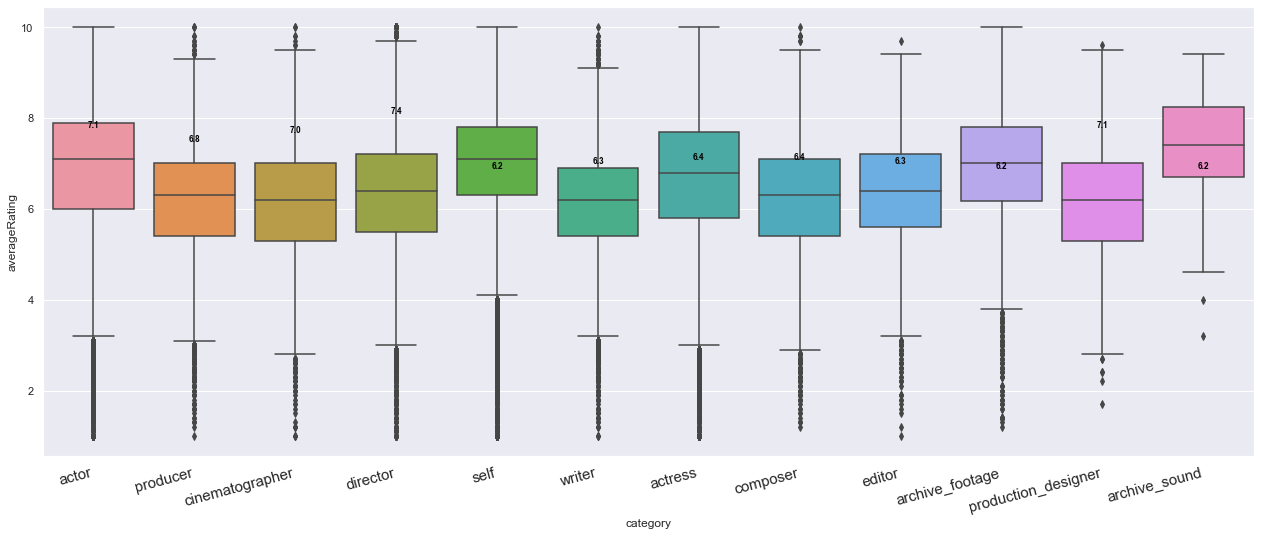

In [84]:
ax = sns.boxplot(data = df_cat, x='category', y='averageRating')
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right", fontsize=15)
sns.set(rc={'figure.figsize':(21.7,8.27)})
medians = df.groupby(['category'])['averageRating'].median()
vertical_offset = df['averageRating'].median() * 0.1 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='black',weight='semibold')

### Handling genre and knownfor title variable

#### Adding a varibale which has the total number of genres

In [85]:
df['numberofgenre'] = df['genres'].str.count(',') + 1

#### An idea to give plus points if a title is known and does not match with tconst

In [61]:
df['Plus'] = df['tconst'] == df['knownForTitles']

In [66]:
df[(df['Plus'] == 'FALSE') & ( df['knownForTitles'].notnull())]

,tconst,directors,writers,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,category,job,primaryProfession,knownForTitles,averageRating,numVotes,numberofgenre,Plus


#### But there exists no records like that hence will convert knownForTitles as a flag

In [86]:
df['knownForTitles'] = np.where(df['knownForTitles'].isnull(), 0, 1)

In [87]:
df.head()

,tconst,directors,writers,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,category,job,primaryProfession,knownForTitles,averageRating,numVotes,numberofgenre
0,tt0000001,nm0005690,NaN,short,Carmencita,0,1894.0,1.0,"Documentary,Short",NaN,NaN,NaN,0,5.7,1858,2.0
1,tt0000002,nm0721526,NaN,short,Le clown et ses chiens,0,1892.0,5.0,"Animation,Short",NaN,NaN,NaN,0,6.0,243,2.0
2,tt0000005,nm0005690,NaN,short,Blacksmith Scene,0,1893.0,1.0,"Comedy,Short",NaN,NaN,NaN,0,6.2,2455,2.0
3,tt0000005,nm0005690,NaN,short,Blacksmith Scene,0,1893.0,1.0,"Comedy,Short",actor,NaN,actor,1,6.2,2455,2.0
6,tt0000006,nm0005690,NaN,short,Chinese Opium Den,0,1894.0,1.0,Short,NaN,NaN,NaN,0,5.2,163,1.0


### Handling genre and knownForTitles variables ( This could be used later on if accuracy is less)

In [19]:
genres_lists = df.genres.str.split(',')        
df.genres = genres_lists 

In [20]:
df = df.explode('genres')

In [24]:
knownForTitles_lists = df.knownForTitles.str.split(',')        
df.knownForTitles = knownForTitles_lists 

In [25]:
df = df.explode('knownForTitles')

In [27]:
df.describe()

,startYear,runtimeMinutes,averageRating,numVotes
count,3.483580e+06,3.008303e+06,3.483875e+06,3.483875e+06
mean,1.995936e+03,5.860408e+01,6.764852e+00,2.346812e+03
std,2.499134e+01,6.946736e+01,1.374452e+00,2.665700e+04
min,1.874000e+03,0.000000e+00,1.000000e+00,5.000000e+00
25%,1.986000e+03,2.400000e+01,6.000000e+00,2.100000e+01
50%,2.005000e+03,5.000000e+01,7.000000e+00,7.900000e+01
75%,2.014000e+03,8.900000e+01,7.800000e+00,3.720000e+02
max,2.022000e+03,5.142000e+04,1.000000e+01,2.543762e+06
